# OpenStreetMap Amenities

In [1]:
%matplotlib inline

In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import geopandas as gpd
import osmium

for module in [pd, gpd]:
    print(module.__name__, module.__version__)

pandas 1.2.3
geopandas 0.9.0


# Overpass API

- [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API)
- [Overpass API/Overpass QL](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL)
- [Overpass Turbo](https://overpass-turbo.eu/) query editor
- [Loading Data from OpenStreetMap with Python and the Overpass API](https://janakiev.com/blog/openstreetmap-with-python-and-overpass-api/)

In [6]:
%%time
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
    [out:json];
    area["ISO3166-1"="AT"][admin_level=2]->.search;
    (node[amenity="restaurant"](area.search);
     way[amenity="restaurant"](area.search);
     rel[amenity="restaurant"](area.search);
    );
    out count;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
response.json()

CPU times: user 6.34 ms, sys: 0 ns, total: 6.34 ms
Wall time: 18.6 s


{'version': 0.6,
 'generator': 'Overpass API 0.7.56.9 76e5016d',
 'osm3s': {'timestamp_osm_base': '2021-04-12T08:18:57Z',
  'timestamp_areas_base': '2021-04-12T07:52:27Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': [{'type': 'count',
   'id': 0,
   'tags': {'nodes': '12610',
    'ways': '6718',
    'relations': '174',
    'areas': '0',
    'total': '19502'}}]}

# Download OpenStreetMap Extract

- __Geofabrik__ ([download.geofabrik.de](http://download.geofabrik.de/))
- __BBBike__ [OSM ready extracts](https://download.bbbike.org/osm/bbbike/)
    - Vienna data set: https://download.bbbike.org/osm/bbbike/Wien/

In [9]:
%%bash
wget https://download.bbbike.org/osm/bbbike/Wien/Wien.osm.pbf \
    --quiet -O data/Wien.osm.pbf

# PyOsmium

- [PyOsmium](https://osmcode.org/pyosmium/)
- [PyOsmium - Documentation](https://docs.osmcode.org/pyosmium/latest/index.html)

In [3]:
from collections import defaultdict

class AmenityStatsHandler(osmium.SimpleHandler):
    def __init__(self):
        super(AmenityStatsHandler, self).__init__()
        self.amenities = defaultdict(int)
    
    def node(self, n):
        for tag in n.tags:
            if tag.k == 'amenity':
                self.amenities[tag.v] += 1

    def way(self, w):
        for tag in w.tags:
            if tag.k == 'amenity':
                self.amenities[tag.v] += 1

    def relation(self, r):
        for tag in r.tags:
            if tag.k == 'amenity':
                self.amenities[tag.v] += 1

In [4]:
%%time
src_filepath = "data/Wien.osm.pbf"

handler = AmenityStatsHandler()
handler.apply_file(src_filepath)

s_amenities = pd.Series(handler.amenities)

CPU times: user 3min 5s, sys: 467 ms, total: 3min 5s
Wall time: 3min 3s


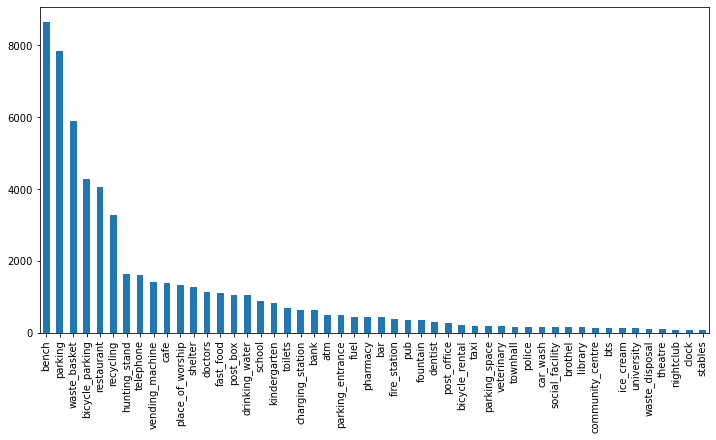

In [14]:
s_amenities.sort_values(ascending=False)[:50] \
  .plot(kind='bar', figsize=(12, 6));

# ogr2ogr

- [ogr2ogr - Documentation](https://gdal.org/programs/ogr2ogr.html)
- [ogr2ogr - OSM - OpenStreetMap XML and PBF](https://gdal.org/drivers/vector/osm.html)

In [3]:
!ogrinfo data/Wien.osm.pbf

INFO: Open of `data/Wien.osm.pbf'
      using driver `OSM' successful.
1: points (Point)
2: lines (Line String)
3: multilinestrings (Multi Line String)
4: multipolygons (Multi Polygon)
5: other_relations (Geometry Collection)


In [13]:
%%bash
ogr2ogr -f "GPKG" \
    data/vienna-amenities.gpkg \
    data/Wien.osm.pbf \
    -where "amenity is not null" \
    POINTS \
    -nln amenity

0...10...20...30...40...50...60...70...80...90...100 - done.


In [33]:
gdf = gpd.read_file("data/vienna-amenities.gpkg", driver='GPKG')
gdf.head(2)

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,osm_id,name,barrier,highway,ref,address,is_in,place,man_made,amenity,other_tags,geometry
0,1634625,None,None,None,None,None,None,None,None,recycling,"""recycling:glass_bottles""=>""yes"",""recycling:gr...",POINT (16.29701 48.18111)
1,15079895,None,None,None,None,None,None,None,None,telephone,None,POINT (16.28689 48.19691)


In [40]:
gdf['amenity'].value_counts()[:10]

bench              8547
waste_basket       5886
bicycle_parking    4074
restaurant         3277
recycling          3045
hunting_stand      1642
telephone          1615
vending_machine    1413
cafe               1306
doctors            1057
Name: amenity, dtype: int64

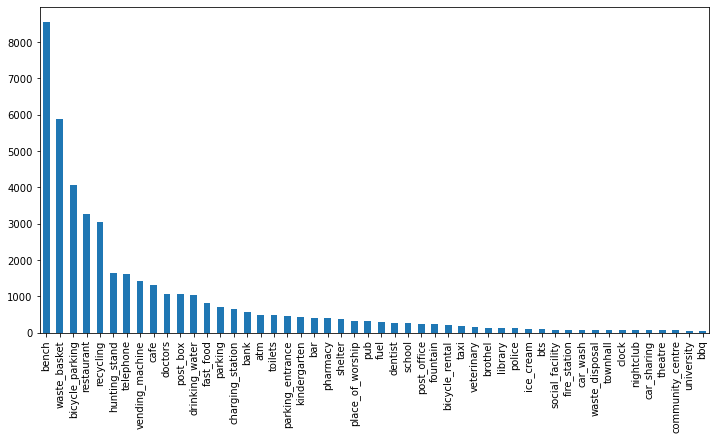

In [39]:
gdf['amenity'].value_counts()[:50].plot(kind='bar', figsize=(12, 6));

# Resources

- [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API)
- [Overpass API/Overpass QL](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL)
- [Overpass Turbo](https://overpass-turbo.eu/) query editor
- [Loading Data from OpenStreetMap with Python and the Overpass API](https://janakiev.com/blog/openstreetmap-with-python-and-overpass-api/)
- [PyOsmium](https://osmcode.org/pyosmium/)
- [PyOsmium - Documentation](https://docs.osmcode.org/pyosmium/latest/index.html)
- [ogr2ogr - Documentation](https://gdal.org/programs/ogr2ogr.html)
- [ogr2ogr - OSM - OpenStreetMap XML and PBF](https://gdal.org/drivers/vector/osm.html)